# k-Means Example
Random Synthetic Data 

1. What the popular clustering techniques are and when to use them
2. What the k-means algorithm is
3. How to implement k-means clustering in Python
4. How to evaluate the performance of clustering algorithms
5. How to build and tune a robust k-means clustering pipeline in Python
6. How to analyze and present clustering results from the k-means algorithm



In [1]:
# importing the modules 
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
import os
from pathlib import Path
currentDir = os.getcwd()
print(currentDir)

dataDir = os.path.join(currentDir, 'split_by_month_output/000')
print(dataDir)

parseDir = Path(dataDir).rglob('*.csv')
files = [x for x in parseDir]

/home/jeffmur/dev/urbanDataR/geolife
/home/jeffmur/dev/urbanDataR/geolife/split_by_month_output/000


In [4]:
features, true_lables = make_blobs(
    n_samples=345,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

In [5]:
features[:5]

array([[  3.40219879,   3.686007  ],
       [  4.58758426,  -0.78378607],
       [ -4.33263894,  -1.62921383],
       [-10.72568802,  -5.33194419],
       [  7.55054618,  -2.8633639 ]])

In [6]:
true_lables[:5]

array([1, 1, 2, 2, 1])

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[ 0.90128045,  0.32484976],
       [ 1.11288954, -0.30272009],
       [-0.47950414, -0.42142021],
       [-1.62075933, -0.94129259],
       [ 1.6418227 , -0.59469789]])

In [11]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [14]:
print(kmeans.inertia_)

print(kmeans.cluster_centers_)

print(kmeans.n_iter_)

124.95219765228866
[[ 1.19355465  0.05308705]
 [-0.96843271 -1.16706996]
 [-0.17743533  1.07832254]]
3


In [15]:
kmeans.labels_[:5]

array([0, 0, 1, 1, 0], dtype=int32)

## Elbow Method
There’s a sweet spot where the SSE curve starts to bend known as the elbow point. 

The x-value of this point is thought to be a reasonable trade-off between error and number of clusters.

In [16]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

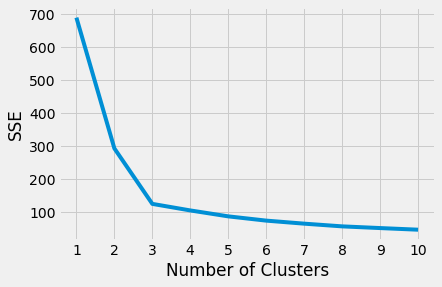

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

print(kl.elbow)

3


## Silhousette Coefficent
The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

    1. How close the data point is to other points in the cluster
    2. How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters. 

In [19]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

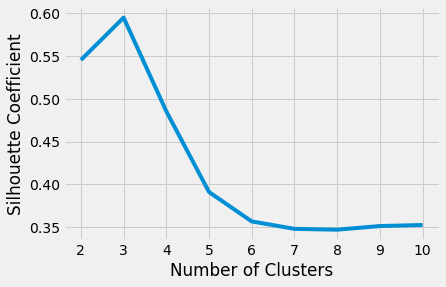

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Advanced Technique via the ground truth
Ground truth labels categorize data points into groups based on assignment by a human or an existing algorithm. These types of metrics do their best to suggest the correct number of clusters but can be deceiving when used without context.

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [22]:
features, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)
scaled_features = scaler.fit_transform(features)

In [23]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(2)

dbscan_silhouette = silhouette_score(
    scaled_features, dbscan.labels_
).round (2)

In [24]:
print(kmeans_silhouette)

print(dbscan_silhouette)

0.5
0.38


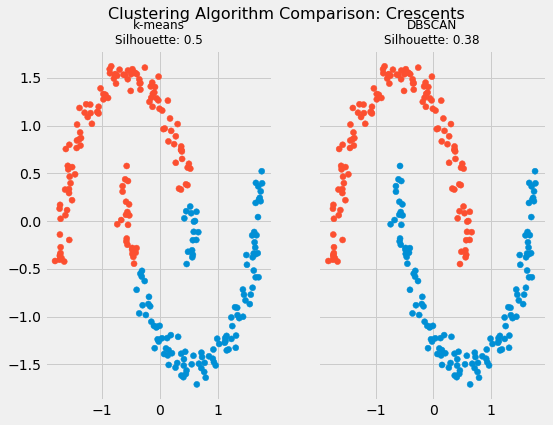

In [27]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12}
)
# The dbscan plot
db_colors = [fte_colors[label] for label in dbscan.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=db_colors)
ax2.set_title(
    f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

In [28]:
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)

print(round(ari_kmeans, 2))
print(round(ari_dbscan, 2))

0.47
1.0
